# Customer Segmentation (RFM Analysis)
### In this notebook, the purchases made by around 4000 customers in a period of one year (12/02/2010 - 12/09/2012) is analysed. The customers are further segregated into segments based on Recency, Frequency and Monetary Value (RFM) parameters which can be used to perform target marketing
### Contents:

1. Data Preparation<br>
    1.1 Data Import<br>
    1.2 Data Overview Statistics<br>
    1.3 Handling Missing values<br>
    1.4 Duplicate Record Check<br><br>
2. Data Exploration <br>
    2.1 Data Level Check <br>
    2.2 Handling Cancelation orders<br>
    2.3 Univariate analysis<br>
    2.4 Creating Calcuated Fields<br>
    2.5 Order Analysis<br>
    2.6 Frequency Analysis<br><br>
3. Customer Segmentation(RFM)<br>
    3.1 Cohort Analysis<br>
    3.2 Calculating Rentention Rates<br>
    3.3 Creating RFM fields<br>
    3.4 Data Pre-processing<br>
    3.5 KMeans Clustering<br>
    3.6 Output interpretation<br><br>
4. Conclusion


### 1. Data Preparation

#### 1.1 Data Import
#### Importing all required libraries

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import path

import nltk
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

##### Importing the raw data file and get an overview of the dimensions. <br> The data can be download from the UCI Machine learning repository site (https://archive.ics.uci.edu/ml/datasets/online+retail)


In [390]:
retail_raw=pd.read_excel("Online Retail.xlsx",converters={'CustomerID':str})
retail_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### 1.2 Data Overview Statistics

In [398]:
Dataset_info=pd.DataFrame(retail_raw.dtypes)
Dataset_info['Null_values']=retail_raw.isnull().sum()
Dataset_info['Percentage']=retail_raw.isnull().sum()/len(retail_raw)
Dataset_info.rename(columns={0: 'Data Type', 'Null_values': '# of Null Values','Percentage': '%age of Null Values'},inplace=True)

print('Dimension of rawdata: ', retail_raw.shape)

print('\n \nData Type and Null population Information:')
display(Dataset_info)

Dimension of rawdata:  (541909, 8)

 
Data Type and Null population Information:


,Data Type,# of Null Values,%age of Null Values
InvoiceNo,object,0,0.000000
StockCode,object,0,0.000000
Description,object,1454,0.002683
Quantity,int64,0,0.000000
InvoiceDate,datetime64[ns],0,0.000000
UnitPrice,float64,0,0.000000
CustomerID,object,135080,0.249267
Country,object,0,0.000000


#### Information about each column from data dictionary
1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
3. Description: Product (item) name. Nominal. <br>
4. Quantity: The quantities of each product (item) per transaction. Numeric. <br>
5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling. <br>
7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
8. Country: Country name. Nominal, the name of the country where each customer resides. <br>

#### 1.3 Handling Missing values
1. Blank Description - Can be blank. No imputation needed
2. Blank customer ID - Customer ID is a relevant field for the analysis and imputation is not practical and does make sense. Hence, we will go ahead and remove the lines with blank customerIDs 

In [399]:
retail_raw.dropna(subset=['CustomerID'],inplace=True)

Dataset_info=pd.DataFrame(retail_raw.dtypes)
Dataset_info['Null_values']=retail_raw.isnull().sum()
Dataset_info['Percentage']=retail_raw.isnull().sum()/len(retail_raw)
Dataset_info.rename(columns={0: 'Data Type', 'Null_values': '# of Null Values','Percentage': '%age of Null Values'},inplace=True)

print('Dimension of data now: ', retail_raw.shape)
print('\n \nData Type and Null population Information:')
display(Dataset_info)

Dimension of data now:  (406829, 8)

 
Data Type and Null population Information:


,Data Type,# of Null Values,%age of Null Values
InvoiceNo,object,0,0.0
StockCode,object,0,0.0
Description,object,0,0.0
Quantity,int64,0,0.0
InvoiceDate,datetime64[ns],0,0.0
UnitPrice,float64,0,0.0
CustomerID,object,0,0.0
Country,object,0,0.0


##### Looks like all the blank descriptions were part of lines with blank CustomerIDs. We do not have blanks in the resultant dataset

#### 1.4 Duplicate Record Check

In [400]:
print("# of Duplicate Lines: ", retail_raw.duplicated().sum())
retail_data=retail_raw.drop_duplicates()
print('\nDimension of data now: ', retail_data.shape)

# of Duplicate Lines:  5225

Dimension of data now:  (401604, 8)


### 2. Data Exploration

#### 2.1 Data Level Check

In [402]:
# Checking if the data is at a summarized level
level_check=retail_data.groupby(['InvoiceNo','StockCode','Description','InvoiceDate','Quantity','UnitPrice'])['CustomerID'].count().reset_index()
level_check[level_check['CustomerID'] > 1]

,InvoiceNo,StockCode,Description,InvoiceDate,Quantity,UnitPrice,CustomerID


##### There is no ouput. This confirms that the data is at a summarized level. And we have also checked if one invoice corresponds to one customers

#### 2.2 Handling Cancelation orders
##### Two cases can appear in the data: <br> 1. The data will contain an actual entry and the cancellation entry. Both the entries needs to be removed <br> 2. Cancellation pertaining to purchases made prior to the analysis period. Single entries will appear

In [67]:
# Creating a datset with only cancelation entries
retail_data['cancellation_status']=retail_data['InvoiceNo'].str[0:1]
Cancelled_entries=retail_data[retail_data['cancellation_status']=='C']
display(Cancelled_entries.head(2))
print('# of Cancelled Entries',Cancelled_entries.shape[0] )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancellation_status
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,C
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,C


# of Cancelled Entries 8872


##### The first sample observation appears to be a discounted entry which is indicated as a cancellation invoice. However, they are not an actual cancellation. Thus we need to exclude them while searching for cancellation entries

In [122]:
Cancelled_entries=retail_data[(retail_data['cancellation_status']=='C') & (retail_data['StockCode']!='D') ]
display(Cancelled_entries.head(2))
print('# of Cancelled Entries',Cancelled_entries.shape[0] )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancellation_status
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,C
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,C


# of Cancelled Entries 8795


In [130]:
Orginal_entries=retail_data[(retail_data['cancellation_status']!='C') | (retail_data['StockCode'] =='D') ]
display(Orginal_entries.head(2))
print('# of Original Entries',Orginal_entries.shape[0] )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancellation_status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,NaN


# of Original Entries 392809


##### Now we merge back the cancellation entries with the original entries and flagged the potential counterpart. There could be more than 1 counterpart as we are not considering InvoiceID while merging

In [439]:
retail_data1 = retail_data.copy()
retail_final = retail_data.copy()

retail_final['QuantityCanceled'] = 0

entry_to_remove = [] 
doubtful_entry = []

for index, col in  retail_data1.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    test = retail_data1[(retail_data1['CustomerID'] == col['CustomerID']) &
                        (retail_data1['StockCode'] == col['StockCode']) & 
                        (retail_data1['InvoiceDate'] < col['InvoiceDate']) & 
                        (retail_data1['Quantity'] > 0)]
    if (test.shape[0] == 0):
        doubtful_entry.append(index)
        
    elif (test.shape[0] == 1):
        index_order = test.index[0]
        retail_final.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    elif (test.shape[0] > 1):
        test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            retail_final.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break    

In [441]:
retail_clean=retail_final.copy()

In [440]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 8


In [442]:
retail_clean.drop(entry_to_remove, axis = 0, inplace = True)
retail_clean.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = retail_clean[(retail_clean['Quantity'] < 0) & (retail_clean['StockCode'] != 'D')]
print("# of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

# of entries to delete: 1266


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,2010-12-01 14:30:00,2.10,17841,United Kingdom,0
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841,United Kingdom,0
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472,Germany,0
1974,C536548,22242,5 HOOK HANGER MAGIC TOADSTOOL,-5,2010-12-01 14:33:00,1.65,12472,Germany,0
1975,C536548,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,2010-12-01 14:33:00,2.95,12472,Germany,0


In [451]:
#Remove all cancelled entries
retail_data = retail_clean[(retail_clean['Quantity'] > 0) | (retail_clean['StockCode'] == 'D')]
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


#### 2.3 Univariate analysis

In [452]:
# Checking different variables and their summaries

#Invoice Date range
print("Min Date : ", min(retail_data['InvoiceDate']))
print("Max Date : ", max(retail_data['InvoiceDate']))

Min Date :  2010-12-01 08:26:00
Max Date :  2011-12-09 12:50:00


In [453]:
#Invoice Date range
print("Min Unit Price : ", min(retail_data['UnitPrice']))
print("Max Unit Price : ", max(retail_data['UnitPrice']))

Min Unit Price :  0.0
Max Unit Price :  8142.75


In [454]:
# of Unique Customer
print("# of Unique Customers: ",retail_data['CustomerID'].nunique())

# of Unique Customers:  4339


In [456]:
#Summary of transactions by Country
Customer_Stats=retail_data.groupby(['Country']).agg({'CustomerID':['nunique','count']}).reset_index()
Customer_Stats.rename(columns={'nunique':'# of Customers','count':'# of Transactions'})

Country     CustomerID                  
                         # of Customers # of Transactions
0              Australia              9              1184
1                Austria             11               398
2                Bahrain              2                17
3                Belgium             25              2031
4                 Brazil              1                32
5                 Canada              4               151
6        Channel Islands              9               747
7                 Cyprus              8               603
8         Czech Republic              1                25
9                Denmark              9               380
10                  EIRE              3              7229
11    European Community              1                60
12               Finland             12               685
13                France             87              8327
14               Germany             94              9027
15                Greece              4               145
16               Iceland              1               182
17                Israel              3               245
18                 Italy             14               759
19                 Japan              8               321
20               Lebanon              1                45
21             Lithuania              1                35
22                 Malta              2               112
23           Netherlands              9              2364
24                Norway             10              1072
25                Poland              6               330
26              Portugal             19              1453
27                   RSA              1                58
28          Saudi Arabia              1                 9
29             Singapore              1               222
30                 Spain             30              2480
31                Sweden              8               450
32           Switzerland             21              1842
33                   USA              4               179
34  United Arab Emirates              2                68
35        United Kingdom           3921            349301
36           Unspecified              4               241

#### 2.4 Creating Calculated Fields

In [457]:
# Creating a total amount spent column with will be quantity multiplied by unit price
retail_data['TotalSum']=retail_data['UnitPrice'] * (retail_data['Quantity'] - retail_data['QuantityCanceled'])
retail_data.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalSum
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
72254,542237,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-01-26 14:30:00,3.75,12347,Iceland,0,15.0
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,2010-12-07 14:57:00,3.75,12347,Iceland,0,15.0
14950,537626,22727,ALARM CLOCK BAKELIKE RED,4,2010-12-07 14:57:00,3.75,12347,Iceland,0,15.0
14951,537626,22728,ALARM CLOCK BAKELIKE PINK,4,2010-12-07 14:57:00,3.75,12347,Iceland,0,15.0


#### 2.5 Orders Analysis

In [611]:
Orders_amount = pd.DataFrame(retail_data.groupby(['InvoiceNo', 'CustomerID'])['TotalSum'].sum(),columns =['TotalSum']).reset_index()

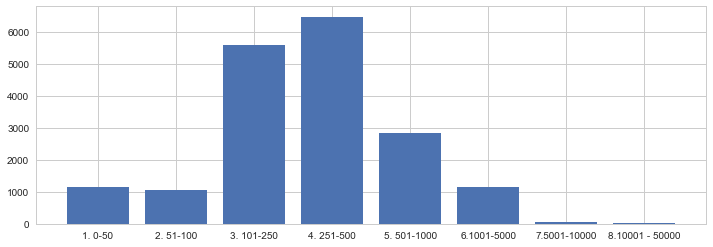

In [612]:
AmountBins=[0,50,100,250,500,1000,5000,10000,50000]
Bin_labels=['1. 0-50','2. 51-100','3. 101-250','4. 251-500', '5. 501-1000', '6.1001-5000', '7.5001-10000', '8.10001 - 50000']
Orders_amount['Amt_Category_Flag']=pd.cut(Orders_amount['TotalSum'],bins=AmountBins,labels=Bin_labels)
Orders_Stats=Orders_amount.groupby(['Amt_Category_Flag'])['InvoiceNo'].count()
Orders_Stats=pd.DataFrame(Orders_Stats).reset_index()
plt.figure(figsize=(12,4))
plt.bar(Orders_Stats['Amt_Category_Flag'],Orders_Stats['InvoiceNo']);

##### Majority of the purchases are ranging in amount 101 - 500

#### 2.6 Frequency Analysis

In [622]:
Customer_Frequency = pd.DataFrame(Orders_amount.groupby(['CustomerID'])['InvoiceNo'].count()).reset_index()
Customer_Frequency['InvoiceNo'].sum()

18601

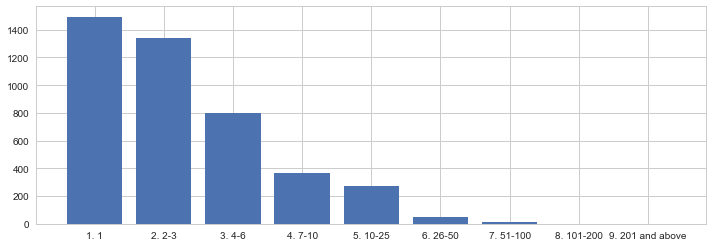

In [636]:
CountBins=[0,1,3,6,10,25,50,100,200,50000]
Count_Bin_labels=['1. 1','2. 2-3','3. 4-6','4. 7-10','5. 10-25','6. 26-50', '7. 51-100', '8. 101-200', '9. 201 and above']
Customer_Frequency['Count_Category_Flag']=pd.cut(Customer_Frequency['InvoiceNo'],bins=CountBins,labels=Count_Bin_labels)
Frequency_Stats=Customer_Frequency.groupby(['Count_Category_Flag'])['InvoiceNo'].count()
Frequency_Stats=pd.DataFrame(Frequency_Stats).reset_index()
plt.figure(figsize=(12,4))
plt.bar(Frequency_Stats['Count_Category_Flag'],Frequency_Stats['InvoiceNo']);

In [648]:
Customer_Frequency[(Customer_Frequency['Count_Category_Flag']=='7. 51-100')|(Customer_Frequency['Count_Category_Flag']=='9. 201 and above')|(Customer_Frequency['Count_Category_Flag']=='8. 101-200')]

,CustomerID,InvoiceNo,Count_Category_Flag
326,12748,210,9. 201 and above
481,12971,86,7. 51-100
562,13089,97,7. 51-100
796,13408,66,7. 51-100
997,13694,52,7. 51-100
1070,13798,57,7. 51-100
1334,14156,55,7. 51-100
1603,14527,83,7. 51-100
1662,14606,93,7. 51-100
1690,14646,75,7. 51-100


##### These customers could be retailers as they have unusually large purchases

### 3. Customer Segmentation(RFM)

#### 3.1 Cohort Analysis

In [521]:
retail_CS = retail_data.drop(retail_data[retail_data.Quantity < 0].index).drop(retail_data[retail_data.UnitPrice == 0].index).drop(retail_CS[retail_CS['TotalSum'] < 0].index)

retail_CS.drop(retail_CS[retail_CS.TotalSum <= 0].index,inplace=True)

# Creating a function which extracts the year and month
def get_month(x):
    return dt.datetime(x.year,x.month,1)

retail_CS['InvoiceMonth'] = retail_CS['InvoiceDate'].apply(get_month)

In [522]:
retail_CS['CohortMonth'] = retail_CS.groupby(['CustomerID'])['InvoiceMonth'].transform(min)
retail_CS.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalSum,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2010-12-01,2010-12-01


In [523]:
def get_date_inf(df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year, month, day

In [524]:
invoice_year, invoice_month, _ = get_date_inf(retail_CS,'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_inf(retail_CS,'CohortMonth')
years_diff=invoice_year - cohort_year
months_diff=invoice_month - cohort_month
retail_CS['CohortIndex']=years_diff * 12 + months_diff + 1
retail_CS.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalSum,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,2010-12-01,2010-12-01,1


#### 3.2 Calculating Rentention Rates 

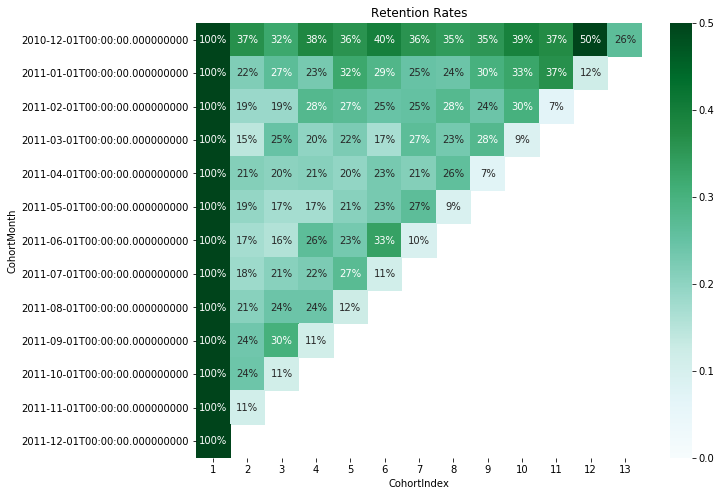

In [525]:
cohort_data=retail_CS.groupby(['CohortMonth','CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts=cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

cohort_sizes=cohort_counts.iloc[:,0]
retention=cohort_counts.divide(cohort_sizes,axis=0)

plt.figure(figsize=(10,8))
plt.title('Retention Rates')
sns.heatmap(data=retention,annot=True,fmt='.0%',vmin=0.0,vmax=0.5,cmap='BuGn');


#### 3.3 Creating RFM fields

In [526]:
snapshot_date=max(retail_CS.InvoiceDate)+dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [527]:
retail_RFM=retail_CS.groupby('CustomerID').agg({'InvoiceDate':lambda x:(snapshot_date-x.max()).days,'InvoiceNo':'count',
                                           'TotalSum': 'sum'})
retail_RFM.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'MonetaryValue'},inplace=True)
retail_RFM.head(2)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347,2,182,4310.00
12348,75,31,1797.24


#### 3.4 Data Pre-processing

In [528]:
retail_RFM.describe()

,Recency,Frequency,MonetaryValue
count,4327.000000,4327.000000,4327.000000
mean,92.697943,90.147446,1940.431575
std,100.183420,224.081232,8394.007364
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,302.185000
50%,51.000000,41.000000,656.630000
75%,143.000000,98.000000,1627.045000
max,374.000000,7614.000000,279765.020000


##### K-Means clustering model assumptions
1. Make sure that the data is symmetrical
2. Mean and variance must be same for all variables

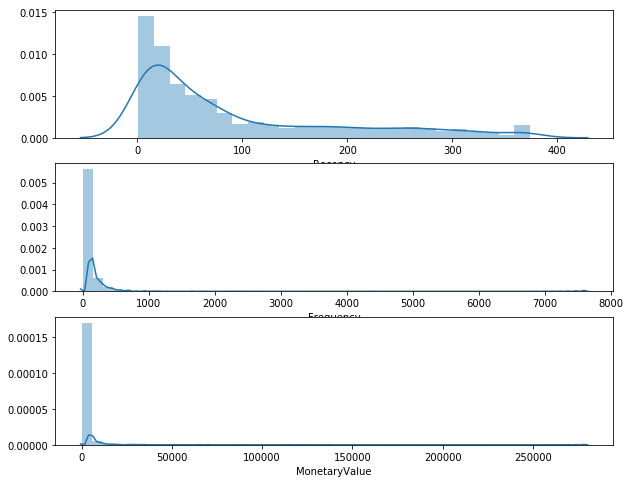

In [530]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
sns.distplot(retail_RFM['Recency'])
plt.subplot(3,1,2)
sns.distplot(retail_RFM['Frequency'])
plt.subplot(3,1,3)
sns.distplot(retail_RFM['MonetaryValue'])

In [531]:
retail_RFM_Log=np.log(retail_RFM)
retail_RFM[retail_RFM['MonetaryValue']==0]

,Recency,Frequency,MonetaryValue
CustomerID,,,


##### We need to apply log transformation on the variables to make it symmetrical


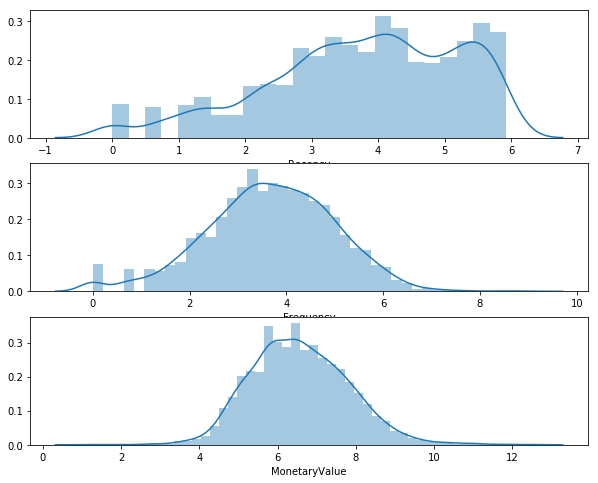

In [532]:
retail_RFM_Log=np.log(retail_RFM)

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
sns.distplot(retail_RFM_Log['Recency'])
plt.subplot(3,1,2)
sns.distplot(retail_RFM_Log['Frequency'])
plt.subplot(3,1,3)
sns.distplot(retail_RFM_Log['MonetaryValue'])

##### Now the data looks almost symmetrical (normally distributed). Next, we will use the standard scaler function to standardize the data

#### 3.5 KMeans Clustering

In [533]:
scaler=StandardScaler()
retail_RFM_normalized=scaler.fit_transform(retail_RFM_Log)

In [534]:
retail_RFM_normalized=pd.DataFrame(retail_RFM_normalized,index=retail_RFM_Log.index, columns=retail_RFM_Log.columns)
retail_RFM_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4327.00,4327.00,4327.00
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.63,-2.77,-4.38
25%,-0.61,-0.63,-0.68
50%,0.11,0.04,-0.06
75%,0.83,0.69,0.66
max,1.50,3.99,4.76


##### Creating KMeans cluster with different values of K and also calculating the SSE for each cluster. The elbow criterion will be used to find the optimal number of cluster

In [535]:
sse={}
for k in range(1,21):
    kmeans=KMeans(n_clusters=k,random_state=1)
    kmeans.fit(retail_RFM_normalized)
    sse[k]=kmeans.inertia_

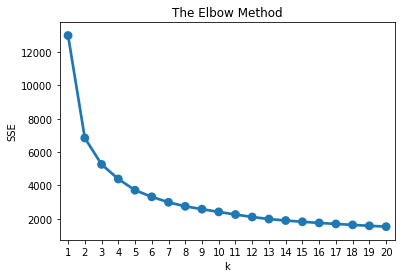

In [536]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))

##### Point at cluster=4 has the largest angle. However, it is better to consider the point 3 and 5 as well to understand which option suits best with business reasoning

##### i.) KMeans Data Statistics with 3 Cluster

In [537]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(retail_RFM_normalized)
cluster_labels = kmeans.labels_

retail_RFM_k3=retail_RFM
retail_RFM_k3 = retail_RFM.assign(Cluster = cluster_labels)
retail_RFM_k3.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          69.0      65.0        1075.0  1852
1          13.0     259.0        6260.0   953
2         172.0      15.0         289.0  1522

##### ii.) KMeans Data Statistics with 4 Clusters

In [538]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(retail_RFM_normalized)
cluster_labels = kmeans.labels_

retail_RFM_k4=retail_RFM
retail_RFM_k4 = retail_RFM.assign(Cluster = cluster_labels)
retail_RFM_k4.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'],}).round(0)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         100.0      77.0        1345.0  1281
1         181.0      14.0         278.0  1358
2          13.0     282.0        6834.0   845
3          19.0      40.0         618.0   843

##### iii.) KMeans Data Statistics with 5 Clusters

In [539]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(retail_RFM_normalized)
cluster_labels = kmeans.labels_

retail_RFM_k5=retail_RFM
retail_RFM_k5 = retail_RFM.assign(Cluster = cluster_labels)
retail_RFM_k5.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'],}).round(0)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          64.0     108.0        1879.0  1023
1         168.0      30.0         496.0  1191
2           9.0     314.0        7938.0   664
3         173.0       7.0         195.0   674
4          17.0      41.0         621.0   775

#### 3.6 Output interpretation

##### The segmentation with 4 clusters looks good as it has segmented the high frequent and high monetary customer with less recency time

In [540]:
retail_RFM_melt=pd.melt(retail_RFM_k4.reset_index(),id_vars=['CustomerID','Cluster'],value_vars=['Recency','Frequency','MonetaryValue'],var_name='Attribute',value_name='Value')
retail_RFM_melt=pd.DataFrame(retail_RFM_melt)

In [ ]:
plt.title('Snake Plot for standardized variables')
sns.plot(x="Attribute",y="Value",hue='Cluster',data=retail_RFM_melt)

In [542]:
cluster_avg = retail_RFM_k4.groupby(['Cluster']).mean()
population_avg = retail_RFM.mean()
relative_imp = cluster_avg / population_avg - 1

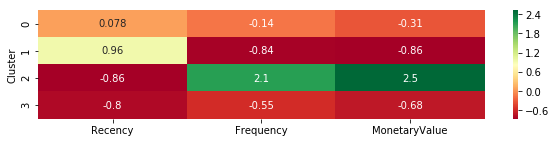

In [543]:
#Relative distance from each parameter
plt.figure(figsize=(10,2))
sns.heatmap(relative_imp,annot=True,cmap='RdYlGn');

### 4. Conclusion


##### First we cleaned up the data by handling missing values and duplicates. Then we tried to removed cancled transaction from data and also identified counterpart of canceled transactions and removed them from the analysis. The remaining data was analysed using RFM analysis and were segmented into different clusters using KMeans clustering techniques. The best number of clusters were determined by the elbow method. We ended up 4 clusters of customer segments and the cluster characteristics were visualized using average calculation and relative importance. Based on these characteristic we can identify strategies to target the groups.